In [155]:
setwd("/Users/rebecca/sudmant/analyses/myotis/analysis/reciprocal_best_hits/contextualize_best_hits")

library(dplyr)
library(tidyr)
library(scales)
library(ggplot2)
library(data.table)
library(RColorBrewer)

myo_meta <- read.csv("../../../data/myotis_meta.csv")

# ortho_gene_mapping <- fread("../../../data/ortholog_mapping.csv", data.table = FALSE)
# scaf_col <- grep("^yum", colnames(ortho_gene_mapping))
# ortho_gene_mapping[,scaf_col] <- gsub("SCAF", "SUPER", ortho_gene_mapping[,scaf_col]) 

In [156]:
# for (i in seq_along(myo_meta$Abbr)) {
#   for (j in seq_along(myo_meta$Abbr)) {
#     if (i != j) {
     
#     }
#   }
# }

In [157]:
i = 1
j = 2

peaks1 <- fread(
  file.path("resources", list.files(path = "resources", pattern = paste0(myo_meta$Abbr[i], "_vs_", myo_meta$Abbr[j], "_.*peaks")))
)
peaks2 <- fread(
  file.path("resources", list.files(path = "resources", pattern = paste0(myo_meta$Abbr[j], "_vs_", myo_meta$Abbr[i], "_.*peaks")))
)

colnames(peaks1)[10] <- "Gene"
colnames(peaks2)[10] <- "Gene"
peaks1$Length  <- with(peaks1, V15 - V14)
peaks2$Length  <- with(peaks2, V15 - V14)
peaks1$Reciprocal_Seq <- with(peaks1, paste(V1, V14, V15))
peaks2$Reciprocal_Seq <- with(peaks2, paste(V1, V14, V15))

peaks1_df <- peaks1 %>%
  dplyr::group_by(V1, Reciprocal_Seq) %>% 
  dplyr::summarise(
    No.Peaks = n(),
    No.Peaks_Rel = n()/unique(Length)
  )

peaks2_df <- peaks2 %>%
  dplyr::group_by(V1, Reciprocal_Seq) %>% 
  dplyr::summarise(
    No.Peaks = n(),
    No.Peaks_Rel = n()/unique(Length)
  )

`summarise()` has grouped output by 'V1'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'V1'. You can override using the `.groups`
argument.


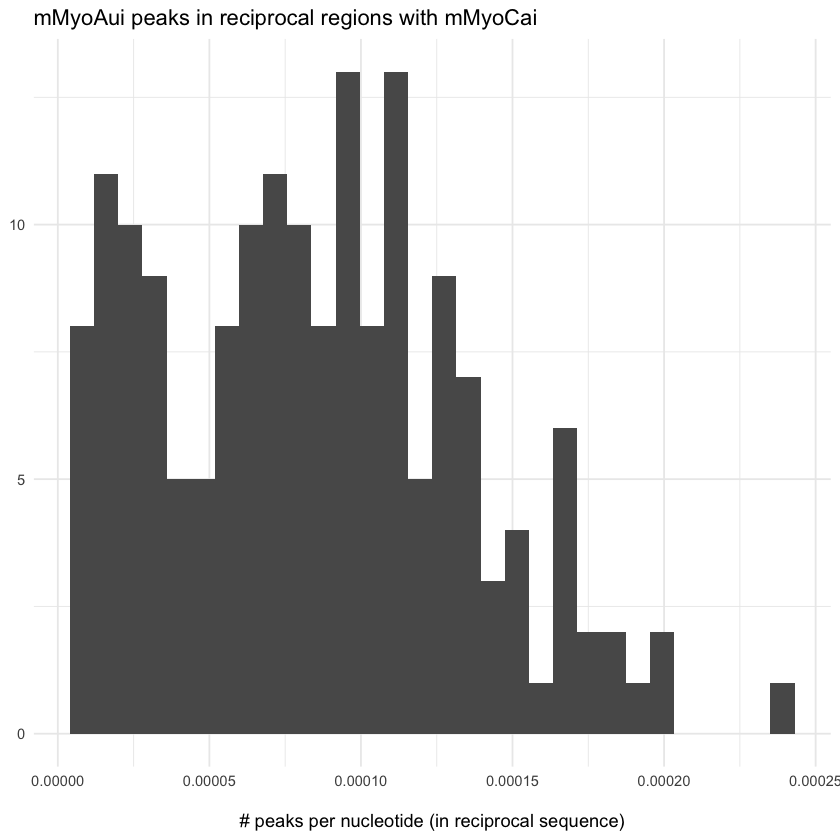

In [158]:
ggplot(peaks1_df, aes(No.Peaks_Rel)) + 
  geom_histogram(bins = 30) +
  theme_minimal() +
  theme(axis.title.x = element_text(margin = margin(t = 15)),
        axis.title.y = element_blank()) +
  labs(title = paste(myo_meta$Abbr[i], "peaks in reciprocal regions with", myo_meta$Abbr[j])) +
  xlab("# peaks per nucleotide (in reciprocal sequence)") +
  scale_x_continuous(breaks = seq(0, 1, by = .00005))

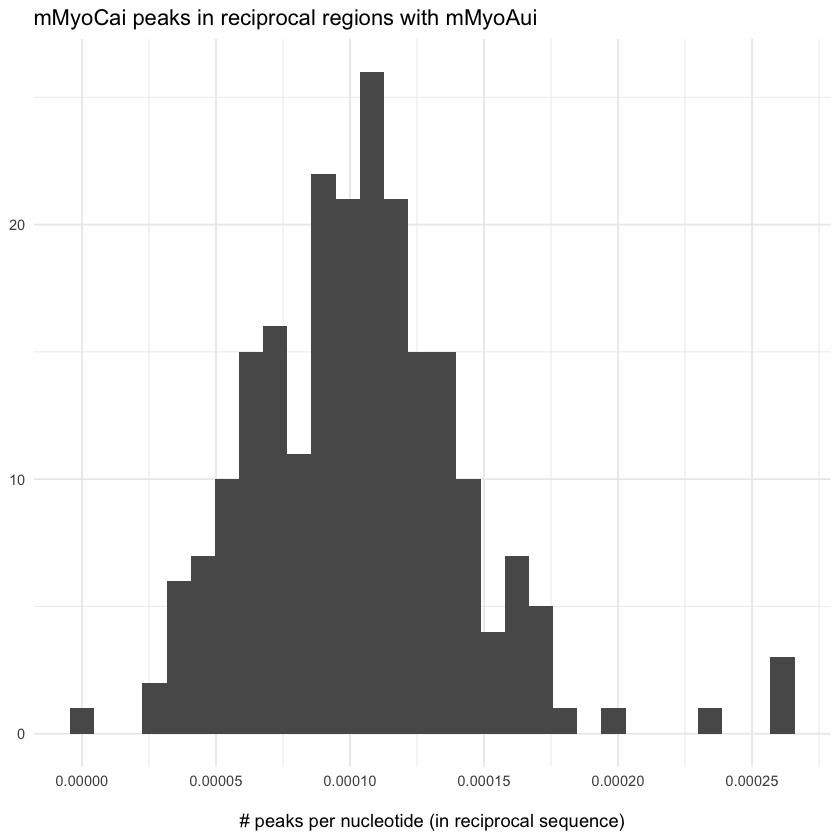

In [159]:
ggplot(peaks2_df, aes(No.Peaks_Rel)) +
  geom_histogram(bins = 30) +
  theme_minimal() +
  theme(axis.title.x = element_text(margin = margin(t = 15)),
        axis.title.y = element_blank()) +
  labs(title = paste(myo_meta$Abbr[j], "peaks in reciprocal regions with", myo_meta$Abbr[i])) +
  xlab("# peaks per nucleotide (in reciprocal sequence)") +
  scale_x_continuous(breaks = seq(0, 1, by = .00005))

In [192]:
## Cross-ref genes from reciprocal best hits with peaks:

hit1_genes <- fread(
  file.path("resources", list.files(path = "resources", pattern = paste0(myo_meta$Abbr[i], "_vs_", myo_meta$Abbr[j], "_.*orthologous")))
)
hit2_genes <- fread(
  file.path("resources", list.files(path = "resources", pattern = paste0(myo_meta$Abbr[j], "_vs_", myo_meta$Abbr[i], "_.*orthologous")))
)

## Format reciprocal hits and peaks prior to merging:
spec1_id <- tolower(gsub("Myotis-", "", myo_meta$Field_Name[i]))
spec2_id <- tolower(gsub("Myotis-", "", myo_meta$Field_Name[j]))
hit1_genes$Gene <- gsub(paste0(spec1_id, "_"), "", hit1_genes$Gene)
hit2_genes$Gene <- gsub(paste0(spec2_id, "_"), "", hit2_genes$Gene)
hit1_genes$Reciprocal_Seq <- with(hit1_genes, paste(V10, V11, V12))
hit2_genes$Reciprocal_Seq <- with(hit2_genes, paste(V10, V11, V12))

hit1_genes <- hit1_genes %>%
  dplyr::select(
    Gene, human_gene_name, myotis_ali_fn, V4, V5, Reciprocal_Seq
  ) %>%
  dplyr::mutate(Gene_Length = V5 - V4)
colnames(hit1_genes)[5:6] <- c("Gene_Start", "Gene_Stop")
hit2_genes <- hit2_genes %>%
  dplyr::select(
    Gene, human_gene_name, myotis_ali_fn, V4, V5, Reciprocal_Seq
  ) %>%
  dplyr::mutate(Gene_Length = V5 - V4)
colnames(hit2_genes)[5:6] <- c("Gene_Start", "Gene_Stop")

peaks1_merge <- peaks1 %>%
  dplyr::select(Gene, V2, V3, Length)
colnames(peaks1_merge)[2:4] <- c("Peak_Start", "Peak_Stop", "Peak_Length")
peaks2_merge <- peaks2 %>%
  dplyr::select(Gene, V2, V3, Length)
colnames(peaks2_merge)[2:4] <- c("Peak_Start", "Peak_Stop", "Peak_Length")

## Annotate gene status:
spec1_gene_status <- merge(hit1_genes, peaks1_merge, by = "Gene", sort = FALSE, all = TRUE)
spec2_gene_status <- merge(hit2_genes, peaks2_merge, by = "Gene", sort = FALSE, all = TRUE)

spec1_gene_status <- spec1_gene_status %>%
  dplyr::group_by(myotis_ali_fn, human_gene_name, Gene) %>% 
  dplyr::summarise(
    Has_Peak = unique(sum(!is.na(Peak_Start)) > 0)
  )
spec2_gene_status <- spec2_gene_status %>%
  dplyr::group_by(myotis_ali_fn, human_gene_name, Gene) %>% 
  dplyr::summarise(
    Has_Peak = unique(sum(!is.na(Peak_Start)) > 0)
  )

`summarise()` has grouped output by 'myotis_ali_fn', 'human_gene_name'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'myotis_ali_fn', 'human_gene_name'. You can
override using the `.groups` argument.


In [196]:
spec1_gene_status <- spec1_gene_status[spec1_gene_status$myotis_ali_fn %in% spec2_gene_status$myotis_ali_fn,]
spec2_gene_status <- spec2_gene_status[match(spec1_gene_status$myotis_ali_fn, spec2_gene_status$myotis_ali_fn),]

[1] 0.1965875

In [ ]:


# ## Get orthologous genes associated with peaks:
# colnames(peaks1)[10] <- "Gene"
# colnames(peaks2)[10] <- "Gene"

# spec1_id <- tolower(gsub("Myotis-", "", myo_meta$Field_Name[i]))
# spec1_gene_mapping <- ortho_gene_mapping[,c(1:3, grep(spec1_id, colnames(ortho_gene_mapping))),]
# colnames(spec1_gene_mapping)[4] <- "Gene"
# spec1_gene_mapping$Gene <- gsub(paste0(spec1_id, "_"), "", spec1_gene_mapping$Gene)
# spec1_gene_mapping <- spec1_gene_mapping[spec1_gene_mapping$Gene %in% peaks1$Gene,]
# spec1_peak_genes <- merge(spec1_gene_mapping, peaks1, by = "Gene", sort = FALSE)

# spec2_id <- tolower(gsub("Myotis-", "", myo_meta$Field_Name[j]))
# spec2_gene_mapping <- ortho_gene_mapping[,c(1:3, grep(spec2_id, colnames(ortho_gene_mapping))),]
# colnames(spec2_gene_mapping)[4] <- "Gene"
# spec2_gene_mapping$Gene <- gsub(paste0(spec2_id, "_"), "", spec2_gene_mapping$Gene)
# spec2_gene_mapping <- spec2_gene_mapping[spec2_gene_mapping$Gene %in% peaks2$Gene,]
# spec2_peak_genes <- merge(spec2_gene_mapping, peaks2, by = "Gene", sort = FALSE)

